# Prepare

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
import datetime
import time
import itertools
import pickle

from VariationalNC.utils import *
from VariationalNC.train import *
from VariationalNC.Variational_layers import VariationalLinear, VariationalConv2d
from VariationalNC.Variational_utils import variational_estimator, ScaleMixtureGaussian
import VariationalNC.activation_max_utils as amu

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
class VanillaCNN(nn.Module):
    def __init__(self,numoffea=48):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        #
        self.conv1 = nn.Conv2d(1,24,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(24,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(24*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        return encoded
#
@variational_estimator
class VariationalCNN(nn.Module):
    def __init__(self,numoffea=48,PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        self.conv1=VariationalConv2d(1,24,kernel_size=(9,9),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#24,23*23
        self.conv2=VariationalConv2d(24,self.numoffea,kernel_size=(7,7),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#48,17*17
        self.fc1  =VariationalLinear(self.numoffea*self.sizeoffea,self.numofneuron,PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)
    def forward(self, x, sampleFlag=False):
        encoded = F.relu(self.conv1(x, sampleFlag))#24,23*23
        encoded = F.relu(self.conv2(encoded, sampleFlag))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded, sampleFlag)) #use exp instead of relu
        return encoded
    
    
    
class VanillaCNN_Dropout(nn.Module):
    def __init__(self,numoffea=48,p=0.5):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        #self.dropout1=nn.Dropout(p=p1)
        #self.dropout2=nn.Dropout(p=p2)
        self.dropout=nn.Dropout(p=p)
        #
        self.conv1 = nn.Conv2d(1,24,kernel_size=9,stride=1)
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(24,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(24*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x)) #24,23*23
        encoded = self.dropout(encoded)
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = self.dropout(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = self.fc1(encoded)
        encoded = self.dropout(encoded)
        encoded = torch.exp(encoded) #use exp instead of relu
        return encoded

In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
train_std = torch.from_numpy(np.array([0.3115977300890251])[None,:,None,None]).float()
print (train_std.shape)

torch.Size([1, 1, 1, 1])


In [4]:
def act_max_pack(
    tempmodel, # model
    train_std, # torch.tensor, from the training data
    unit,         # neuron id
    inputseed = 1,  # for input_img
    sampleFlag=False, # for variational model
    sampleseed=1,     # for variational model
    device=device_cpu,    # only test cpu for now
):
    """
    Activation max, packed function.
    Output: torch.tensor, with a shape of (1, c, h, w), with a std equals to train_std
    """
    tempmodel = tempmodel.to(device)  
    for param in tempmodel.parameters():
        param.requires_grad = False
    tempmodel = tempmodel.eval()
    # for param in tempmodel.parameters():
    #     print (param)
    
    # input_img, should have a shape of (1, c, h, w)
    torch.manual_seed(inputseed)    # reproducible
    input_img = torch.randn(1, 1, 31, 31) * train_std
    
    # model.fc1
    activation_dictionary = {}
    layer_name = 'fc1'
    tempmodel.fc1.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

    # config for activation maximization
    steps = 100                 # perform 100 iterations
    # unit = 95                  # flamingo class of Imagenet
    alpha = torch.tensor(10)   # learning rate (step size) 
    verbose = False              # print activation every step
    L2_Decay = True             # enable L2 decay regularizer
    Gaussian_Blur = True        # enable Gaussian regularizer
    Norm_Crop = True            # enable norm regularizer
    Contrib_Crop = True         # enable contribution regularizer
    # sampleFlag=False          # for variational model
    # sampleseed=4              # for variational model
    
    output = amu.act_max(network=tempmodel,
                input=input_img,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=verbose,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                sampleFlag=sampleFlag,
                sampleseed=sampleseed,
                )
    
    # keep the mean and the std consistent with training data (mean is equal to zeros)
    # output image has the same shape with the input
    output = output - torch.mean(output, dim=(2,3), keepdims=True)
    output = output/torch.std(output, dim=(2,3), keepdims=True)*train_std
    # print (torch.std(output))
    return output


In [5]:
def act_max_pack_dropout(
    tempmodel, # model
    train_std, # torch.tensor, from the training data
    unit,         # neuron id
    inputseed = 1,  # for input_img
    sampleFlag=False, # for variational model
    sampleseed=1,     # for variational model
    device=device_cpu,    # only test cpu for now
):
    """
    Activation max, packed function.
    Output: torch.tensor, with a shape of (1, c, h, w), with a std equals to train_std
    """
    tempmodel = tempmodel.to(device)  
    for param in tempmodel.parameters():
        param.requires_grad = False
    tempmodel = tempmodel.eval()
    # for param in tempmodel.parameters():
    #     print (param)
    
    # input_img, should have a shape of (1, c, h, w)
    torch.manual_seed(inputseed)    # reproducible
    input_img = torch.randn(1, 1, 31, 31) * train_std
    
    # model.fc1
    activation_dictionary = {}
    layer_name = 'fc1'
    tempmodel.fc1.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

    # config for activation maximization
    steps = 100                 # perform 100 iterations
    # unit = 95                  # flamingo class of Imagenet
    alpha = torch.tensor(10)   # learning rate (step size) 
    verbose = False              # print activation every step
    L2_Decay = True             # enable L2 decay regularizer
    Gaussian_Blur = True        # enable Gaussian regularizer
    Norm_Crop = True            # enable norm regularizer
    Contrib_Crop = True         # enable contribution regularizer
    # sampleFlag=False          # for variational model
    # sampleseed=4              # for variational model
    
    output = amu.act_max_dropout(network=tempmodel,
                input=input_img,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=verbose,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                sampleFlag=sampleFlag,
                sampleseed=sampleseed,
                )
    
    # keep the mean and the std consistent with training data (mean is equal to zeros)
    # output image has the same shape with the input
    output = output - torch.mean(output, dim=(2,3), keepdims=True)
    output = output/torch.std(output, dim=(2,3), keepdims=True)*train_std
    # print (torch.std(output))
    return output


# Example unit

## Vanilla

In [54]:
tempmodel= VanillaCNN()   #no regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNNnoregu__trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 1
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_cnn_noregu_Antolik2016.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20211216/activation-max-example-neuron1-acts_seed_'+str(i)+'_cnn_noregu_Antolik2016.npy', out_rcnn)

outs.shape: (1, 103). Neuron 1 activation: 6.843786239624023
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.723048210144043
outs.shape: (1, 103). Neuron 1 activation: 6.457357883453369
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.610079765319824
outs.shape: (1, 103). Neuron 1 activation: 6.6066575050354
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.519016265869141
outs.shape: (1, 103). Neuron 1 activation: 6.933645248413086
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.588929176330566
outs.shape: (1, 103). Neuron 1 activation: 6.838047981262207
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.466968059539795


In [56]:
tempmodel= VanillaCNN()   #no regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNNnoregu__trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 56
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_cnn_noregu_Antolik2016.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20211216/activation-max-example-neuron56-acts_seed_'+str(i)+'_cnn_noregu_Antolik2016.npy', out_rcnn)

outs.shape: (1, 103). Neuron 56 activation: 6.783658027648926
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.731386661529541
outs.shape: (1, 103). Neuron 56 activation: 6.814578056335449
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.99329948425293
outs.shape: (1, 103). Neuron 56 activation: 7.240443706512451
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.639117240905762
outs.shape: (1, 103). Neuron 56 activation: 8.301836013793945
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.891858100891113
outs.shape: (1, 103). Neuron 56 activation: 7.8515729904174805
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.73311710357666


In [42]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN_'+'_seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 1
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_rcnn_Antolik2016.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20211216/activation-max-example-neuron1-acts_seed_'+str(i)+'_rcnn_Antolik2016.npy', out_rcnn)

outs.shape: (1, 103). Neuron 1 activation: 8.556571960449219
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.297901153564453
outs.shape: (1, 103). Neuron 1 activation: 9.174254417419434
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.324126243591309
outs.shape: (1, 103). Neuron 1 activation: 5.7844672203063965
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.763418674468994
outs.shape: (1, 103). Neuron 1 activation: 7.628983020782471
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.544593334197998
outs.shape: (1, 103). Neuron 1 activation: 7.856869220733643
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.5902886390686035


In [41]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN_'+'_seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 56
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_rcnn=np.array(output.cpu().data.numpy())
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    #np.save('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_rcnn_Antolik2016.npy', outputs_rcnn)
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_rcnn = np.copy(outs)
    #np.save('out_20211216/activation-max-example-neuron56-acts_seed_'+str(i)+'_rcnn_Antolik2016.npy', out_rcnn)

outs.shape: (1, 103). Neuron 56 activation: 9.074846267700195
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.378069877624512
outs.shape: (1, 103). Neuron 56 activation: 10.321415901184082
Test activation: outs.shape: (1, 103). Neuron 56 activation: 3.0479187965393066
outs.shape: (1, 103). Neuron 56 activation: 5.954518795013428
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.824300765991211
outs.shape: (1, 103). Neuron 56 activation: 7.479497909545898
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.542162895202637
outs.shape: (1, 103). Neuron 56 activation: 9.02018928527832
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.847505569458008


(1, 1, 31, 31)


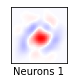

In [55]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_cnn_noregu_Antolik2016.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_with_std_CNN_noregu_neuron1_activation_max.svg')

(1, 1, 31, 31)


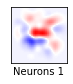

In [58]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_cnn_noregu_Antolik2016.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 56')
#fig.savefig('out_result_20211216/RFs_with_std_CNN_noregu_neuron56_activation_max.svg')

(1, 1, 31, 31)


Text(0.5, 0, 'Neurons 1')

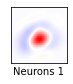

In [26]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_rcnn_Antolik2016.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_with_std_rCNN_neuron1_activation_max.svg')

(1, 1, 31, 31)


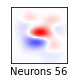

In [53]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_rcnn_Antolik2016.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 56')
#fig.savefig('out_result_20211216/RFs_with_std_rCNN_neuron56_activation_max.svg')

## variation-sampleFlag=False

In [45]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 1
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20211216/activation-max-example-neuron1-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy', out_vcnn)

outs.shape: (1, 103). Neuron 1 activation: 6.064092636108398
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.713443279266357
outs.shape: (1, 103). Neuron 1 activation: 6.017462730407715
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.422936916351318
outs.shape: (1, 103). Neuron 1 activation: 6.038795471191406
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.685201644897461
outs.shape: (1, 103). Neuron 1 activation: 6.945292949676514
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.249328136444092
outs.shape: (1, 103). Neuron 1 activation: 7.736034870147705
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.320013046264648


In [46]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 56
    inputseed = 1
    sampleFlag = False
    sampleseed = 1
    output = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    outputs_vcnn=np.array(output.cpu().data.numpy())
    #np.save('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy', outputs_vcnn)
    outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

    outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
    out_vcnn = np.copy(outs)
    #np.save('out_20211216/activation-max-example-neuron56-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy', out_vcnn)

outs.shape: (1, 103). Neuron 56 activation: 6.351404666900635
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.879813194274902
outs.shape: (1, 103). Neuron 56 activation: 6.7593092918396
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.799915790557861
outs.shape: (1, 103). Neuron 56 activation: 6.44511604309082
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.6868743896484375
outs.shape: (1, 103). Neuron 56 activation: 7.971915245056152
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.655875205993652
outs.shape: (1, 103). Neuron 56 activation: 9.135623931884766
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.648715019226074


(1, 1, 31, 31)


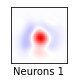

In [49]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_with_std_VCNN_neuron1_activation_max.svg')

(1, 1, 31, 31)


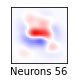

In [50]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy')
print (RF_fl_np.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np[0,0]
tempmax=np.max(np.abs(RF_fl_np[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 56')
#fig.savefig('out_result_20211216/RFs_with_std_VCNN_neuron56_activation_max.svg')

(100, 1, 1, 31, 31)
(1, 1, 31, 31)


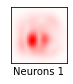

In [96]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Antolik2016.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_with_std_VCNN_neuron1_std_activation_max.svg')

(100, 1, 1, 31, 31)
(1, 1, 31, 31)


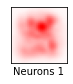

In [97]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Antolik2016.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_with_std_VCNN_neuron56_std_activation_max.svg')

## Variational-sampleFlag=True

In [88]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 1
    inputseed = 1
    sampleFlag = True
    sampleseeds = np.arange(100).tolist()
    tempoutputs = []
    tempacts = []
    for ii, sampleseed in enumerate(sampleseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput.cpu().data.numpy())
        tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        
        tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        tempacts.append(tempact)
    tempacts = np.copy(tempacts)
    #np.save('out_20211216/activation-max-example-neuron1-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Antolik2016.npy', tempacts)
    tempoutputs = np.array(tempoutputs)
    #np.save('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Antolik2016.npy', tempoutputs)

outs.shape: (1, 103). Neuron 1 activation: 5.87982702255249
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.38391637802124
outs.shape: (1, 103). Neuron 1 activation: 5.60020637512207
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.080752849578857
outs.shape: (1, 103). Neuron 1 activation: 5.407264709472656
Test activation: outs.shape: (1, 103). Neuron 1 activation: 5.892563819885254
outs.shape: (1, 103). Neuron 1 activation: 5.645570755004883
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.260560512542725
outs.shape: (1, 103). Neuron 1 activation: 5.578149795532227
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.057277202606201
outs.shape: (1, 103). Neuron 1 activation: 5.953299522399902
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.437410354614258
outs.shape: (1, 103). Neuron 1 activation: 5.841254711151123
Test activation: outs.shape: (1, 103). Neuron 1 activation: 6.428382396697998
outs.shape: (1, 103). Neuron 1

In [89]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    unit = 56
    inputseed = 1
    sampleFlag = True
    sampleseeds = np.arange(100).tolist()
    tempoutputs = []
    tempacts = []
    for ii, sampleseed in enumerate(sampleseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput.cpu().data.numpy())
        tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        
        tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
        tempacts.append(tempact)
    tempacts = np.copy(tempacts)
    np.save('out_20211216/activation-max-example-neuron56-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Antolik2016.npy', tempacts)
    tempoutputs = np.array(tempoutputs)
    np.save('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Antolik2016.npy', tempoutputs)

outs.shape: (1, 103). Neuron 56 activation: 5.942653179168701
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.6372246742248535
outs.shape: (1, 103). Neuron 56 activation: 6.115506172180176
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.843800067901611
outs.shape: (1, 103). Neuron 56 activation: 6.095776081085205
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.729866981506348
outs.shape: (1, 103). Neuron 56 activation: 5.809968948364258
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.553189277648926
outs.shape: (1, 103). Neuron 56 activation: 5.74061918258667
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.807314872741699
outs.shape: (1, 103). Neuron 56 activation: 5.9669342041015625
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.567176342010498
outs.shape: (1, 103). Neuron 56 activation: 5.991313934326172
Test activation: outs.shape: (1, 103). Neuron 56 activation: 5.702939987182617
outs.shape: 

## dropout

In [82]:
tempmodels= ['VanillaCNN_Dropout']
model_parameters = {'p': 0.7}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=2
tempmodel.load_state_dict(torch.load('./out_20211216/' + 'VanillaCNN_Dropout_trainnum_1_Antolik2016Data_trainN__seed_' + str(i) +'.pth'))
torch.manual_seed(seeds[i])    # reproducible
torch.cuda.manual_seed(seeds[i])
unit = 1
inputseed = 1
sampleFlag = False
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack_dropout(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20211216/activation-max-example-neuron1-acts_seed_'+str(i)+'_dropout_Antolik2016.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_dropout_Antolik2016.npy', tempoutputs)

outs.shape: (1, 103). Neuron 1 activation: 5.576379299163818
Test activation: outs.shape: (1, 103). Neuron 1 activation: 4.952761650085449
outs.shape: (1, 103). Neuron 1 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 1 activation: 4.486324787139893
outs.shape: (1, 103). Neuron 1 activation: 6.19843053817749
Test activation: outs.shape: (1, 103). Neuron 1 activation: 4.908308506011963
outs.shape: (1, 103). Neuron 1 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 1 activation: 5.3372111320495605
outs.shape: (1, 103). Neuron 1 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 1 activation: 5.735325336456299
outs.shape: (1, 103). Neuron 1 activation: 6.775107383728027
Test activation: outs.shape: (1, 103). Neuron 1 activation: 4.784388542175293
outs.shape: (1, 103). Neuron 1 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 1 activation: 4.073864936828613
outs.shape: (1, 103). Neuron 1 activation: 0.0
Test activation: outs.shape: (1, 103

In [93]:
tempmodels= ['VanillaCNN_Dropout']
model_parameters = {'p': 0.7}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

i=2
tempmodel.load_state_dict(torch.load('./out_20211216/' + 'VanillaCNN_Dropout_trainnum_1_Antolik2016Data_trainN__seed_' + str(i) +'.pth'))
torch.manual_seed(seeds[i])    # reproducible
torch.cuda.manual_seed(seeds[i])
unit = 56
inputseed = 1
sampleFlag = False
sampleseeds = np.arange(100).tolist()
tempoutputs = []
tempacts = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack_dropout(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())
    tempact = np.log(tempmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')

    tempact = np.log(testmodel( tempoutput ).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {tempact[0, unit]}')
    tempacts.append(tempact)
tempacts = np.copy(tempacts)
#np.save('out_20211216/activation-max-example-neuron56-acts_seed_'+str(i)+'_dropout_Antolik2016.npy', tempacts)
tempoutputs = np.array(tempoutputs)
#np.save('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_dropout_Antolik2016.npy', tempoutputs)

outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.259974002838135
outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 3.650298833847046
outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 3.9211926460266113
outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.522310733795166
outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.392901420593262
outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.241245746612549
outs.shape: (1, 103). Neuron 56 activation: 0.0
Test activation: outs.shape: (1, 103). Neuron 56 activation: 4.454704284667969
outs.shape: (1, 103). Neuron 56 activation: 7.338007926940918
Test activation: outs.shape: (1, 103). Neuron 56

(100, 1, 1, 31, 31)
(1, 1, 31, 31)


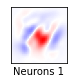

In [90]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_dropout_Antolik2016.npy')
print (RF_fl_np.shape)
RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
print(RF_fl_np_mean.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_mean[0,0]
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_CNN_dropout_neuron1_activation_max.svg')

(100, 1, 1, 31, 31)
(1, 1, 31, 31)


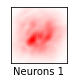

In [91]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron1-outputs_seed_'+str(i)+'_dropout_Antolik2016.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 1')
#fig.savefig('out_result_20211216/RFs_with_std_CNN_dropout_neuron1_activation_max.svg')

(100, 1, 1, 31, 31)
(1, 1, 31, 31)


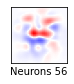

In [94]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_dropout_Antolik2016.npy')
print (RF_fl_np.shape)
RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
print(RF_fl_np_mean.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_mean[0,0]
tempmax=np.max(np.abs(temp))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 56')
#fig.savefig('out_result_20211216/RFs_CNN_dropout_neuron56_activation_max.svg')

(100, 1, 1, 31, 31)
(1, 1, 31, 31)


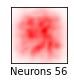

In [95]:
i=2
RF_fl_np=np.load('out_20211216/activation-max-example-neuron56-outputs_seed_'+str(i)+'_dropout_Antolik2016.npy')
print(RF_fl_np.shape)
RF_fl_np_std=np.std(RF_fl_np,axis=0,ddof=1) 
print(RF_fl_np_std.shape)
nrows,ncols=1,1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols,3))
temp=RF_fl_np_std[0,0]
tempmax=np.max(np.abs(RF_fl_np_std[0,0]))
axes.imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
axes.grid(False)#axes[ii,jj].axis('tight')
axes.set_xticks([])
axes.set_yticks([])
axes.set_xlabel('Neurons 56')
#fig.savefig('out_result_20211216/RFs_with_std_CNN_dropout_neuron56_activation_max.svg')

## Load data

In [5]:
activations_neuron95_rcnn=np.zeros([5,161])
RF_neuron95_rcnn=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_rcnn[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
    activations_neuron95_rcnn[i]=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')

    
activations_neuron123_rcnn=np.zeros([5,161])
RF_neuron123_rcnn=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron123_rcnn[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_rcnn_Franke2021.npy')
    activations_neuron123_rcnn[i]=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_rcnn_Franke2021.npy')

    
activations_neuron95_vcnn_false=np.zeros([5,161])
RF_neuron95_vcnn_false=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    activations_neuron95_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')

    
activations_neuron123_vcnn_false=np.zeros([5,161])
RF_neuron123_vcnn_false=np.zeros([5,1,2,36,64])
for i in range(5):
    RF_neuron123_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')
    activations_neuron123_vcnn_false[i]=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Franke2021.npy')

    
activations_neuron95_vcnn_true=np.zeros([5,100,1,161])
RF_neuron95_vcnn_true=np.zeros([5,100,1,2,36,64])
for i in range(5):
    RF_neuron95_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    activations_neuron95_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron95-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')

activations_neuron123_vcnn_true=np.zeros([5,100,1,161])
RF_neuron123_vcnn_true=np.zeros([5,100,1,2,36,64])
for i in range(5):
    RF_neuron123_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron123-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
    activations_neuron123_vcnn_true[i]=np.load('out_20220423/activation-max-example-neuron123-acts_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')

In [64]:
print("neuron 95:")
print("rcnn:",activations_neuron95_rcnn[:,95])
print("vcnn_f:",activations_neuron95_vcnn_false[:,95])
print("vcnn_t  mean of 100 sample:", np.mean(activations_neuron95_vcnn_true[:,:,:,95],axis=1).squeeze())
print("vcnn_t  mean of 20 sample:", np.mean(activations_neuron95_vcnn_true[:,:20,:,95],axis=1).squeeze())
print("vcnn_t  max of 100 sample:", np.max(activations_neuron95_vcnn_true[:,:,:,95],axis=1).squeeze())
print("vcnn_t  max of 20 sample:", np.max(activations_neuron95_vcnn_true[:,:20,:,95],axis=1).squeeze())


print("neuron 123:")
print(activations_neuron123_rcnn[:,123])
print(activations_neuron123_vcnn_false[:,123])
print("vcnn_t mean of 100 sample:",np.mean(activations_neuron123_vcnn_true[:,:,:,123],axis=1).squeeze())
print("vcnn_t mean of 20 sample:",np.mean(activations_neuron123_vcnn_true[:,:20,:,123],axis=1).squeeze())
print("vcnn_t  max of 100 sample:", np.max(activations_neuron123_vcnn_true[:,:,:,123],axis=1).squeeze())
print("vcnn_t  max of 20 sample:", np.max(activations_neuron123_vcnn_true[:,:20,:,123],axis=1).squeeze())

neuron 95:
rcnn: [ 9.36610413 11.33405113  9.13478661  9.33824253 11.05596638]
vcnn_f: [11.46407318 12.4668045  11.85247707 12.35008144  9.47778797]
vcnn_t  mean of 100 sample: [10.34924222 10.99529485 10.01387681 10.23548036  8.47881441]
vcnn_t  mean of 20 sample: [10.35805292 11.01877675 10.05815997 10.08481691  8.48384345]
vcnn_t  max of 100 sample: [11.14703369 11.96807098 11.01191235 11.58817577 11.41462231]
vcnn_t  max of 20 sample: [10.83459663 11.96807098 10.8782692  11.27744579 10.70974255]
neuron 123:
[10.69647312 11.3203392  11.18883228 11.05544281 11.73458195]
[10.62659454 11.53069592 11.01009369 11.2011795  10.53444004]
vcnn_t mean of 100 sample: [ 9.92261716 10.52637919 10.0611161  10.25853663  9.52670456]
vcnn_t mean of 20 sample: [ 9.96781564 10.58368616  9.99091411 10.21796021  9.52421393]
vcnn_t  max of 100 sample: [10.85474205 11.34074497 10.85150909 11.0474081  10.63217545]
vcnn_t  max of 20 sample: [10.80373478 11.34074497 10.5520649  11.0474081  10.34209728]


In [65]:
tempotput=np.mean(RF_neuron95_rcnn,axis=0)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

unit=95
temprf= tempotput  
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Neuron {unit} activation: {tempact[0, unit]}')


(1, 2, 36, 64)
Neuron 95 activation: 10.129783630371094


In [66]:
tempotput=np.mean(RF_neuron95_vcnn_false,axis=0)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

unit=95
temprf= tempotput  
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Neuron {unit} activation: {tempact[0, unit]}')

(1, 2, 36, 64)
Neuron 95 activation: 11.55065631866455


In [68]:
tempotput=np.mean(RF_neuron95_vcnn_true,axis=(0,1))
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

unit=95
temprf= tempotput  
tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Neuron {unit} activation: {tempact[0, unit]}')

(1, 2, 36, 64)
Neuron 95 activation: 10.001091003417969


(5, 2, 36, 64)


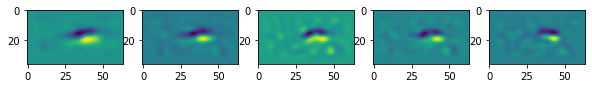

In [63]:
rf_mean_neuron95= np.mean(RF_neuron95_vcnn_true,axis=1).squeeze()
print(rf_mean_neuron95.shape)

fig,ax=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
ax[0].imshow(rf_mean_neuron95[0,0])
ax[1].imshow(rf_mean_neuron95[1,0])
ax[2].imshow(rf_mean_neuron95[2,0])
ax[3].imshow(rf_mean_neuron95[3,0])
ax[4].imshow(rf_mean_neuron95[4,0])

(5, 2, 36, 64)


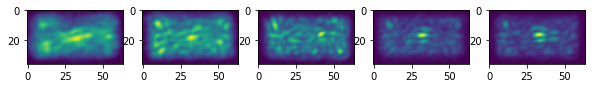

In [54]:
rf_std_neuron95=np.std(RF_neuron95_vcnn_true,axis=1,ddof=1).squeeze()
print(rf_std_neuron95.shape)

fig,ax=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
ax[0].imshow(rf_std_neuron95[0,0])
ax[1].imshow(rf_std_neuron95[1,0])
ax[2].imshow(rf_std_neuron95[2,0])
ax[3].imshow(rf_std_neuron95[3,0])
ax[4].imshow(rf_std_neuron95[4,0])

(5, 2, 36, 64)


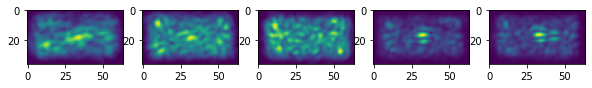

In [58]:
rf_std_neuron95=np.std(RF_neuron95_vcnn_true[:,:20],axis=1,ddof=1).squeeze()
print(rf_std_neuron95.shape)

fig,ax=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
ax[0].imshow(rf_std_neuron95[0,0])
ax[1].imshow(rf_std_neuron95[1,0])
ax[2].imshow(rf_std_neuron95[2,0])
ax[3].imshow(rf_std_neuron95[3,0])
ax[4].imshow(rf_std_neuron95[4,0])

In [59]:
tempotput=np.mean(RF_neuron95_vcnn_true,axis=1)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(5):
    unit=95
    temprf= tempotput[i]    
    tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Neuron {unit} activation: {tempact[0, unit]}')
 

(5, 1, 2, 36, 64)
Neuron 95 activation: 10.364192962646484
Neuron 95 activation: 11.079753875732422
Neuron 95 activation: 10.171868324279785
Neuron 95 activation: 10.132164001464844
Neuron 95 activation: 8.017132759094238


In [26]:
tempotput=np.mean(RF_neuron123_vcnn_true,axis=1)
print(tempotput.shape)

testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for i in range(5):
    unit=123
    temprf= tempotput[i]    
    tempact = np.log(testmodel(torch.from_numpy(temprf).float()).cpu().data.numpy()) # cancel out the last layer - exp layer
    print (f'Neuron {unit} activation: {tempact[0, unit]}')
 

Neuron 123 activation: 9.687178611755371
Neuron 123 activation: 10.232026100158691
Neuron 123 activation: 9.748725891113281
Neuron 123 activation: 9.948089599609375
Neuron 123 activation: 9.130724906921387


## 30 neurons MEIs

In [8]:
example_30_neuron=[0,8,11,16,17,22,25,26,29,30,33,38,39,40,41,43,46,47,50,52,55,59,62,75,65,69,89,92,94,96]

### L2+L1

In [21]:
tempmodel= VanillaCNN()   #with regularization
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for neuron_i in example_30_neuron:
    for i in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN_'+'_seed_'+str(i)+'.pth'))
        torch.manual_seed(seeds[i])    # reproducible
        torch.cuda.manual_seed(seeds[i])
        unit = neuron_i
        inputseed = 1
        sampleFlag = False
        sampleseed = 1
        output = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        outputs_rcnn=np.array(output.cpu().data.numpy())
        outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        #np.save('out_20211216/activation-max-example-neuron'+str(neuron_i)+'-outputs_seed_'+str(i)+'_rcnn_Antolik2016.npy', outputs_rcnn)
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

        outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
        out_rcnn = np.copy(outs)
        #np.save('out_20211216/activation-max-example-neuron'+str(neuron_i)+'-acts_seed_'+str(i)+'_rcnn_Antolik2016.npy', out_rcnn)

outs.shape: (1, 103). Neuron 0 activation: 8.671026229858398
Test activation: outs.shape: (1, 103). Neuron 0 activation: 2.7918360233306885
outs.shape: (1, 103). Neuron 0 activation: 9.18315315246582
Test activation: outs.shape: (1, 103). Neuron 0 activation: 2.616244077682495
outs.shape: (1, 103). Neuron 0 activation: 3.623342514038086
Test activation: outs.shape: (1, 103). Neuron 0 activation: 2.93697452545166
outs.shape: (1, 103). Neuron 0 activation: 6.180628299713135
Test activation: outs.shape: (1, 103). Neuron 0 activation: 3.1766958236694336
outs.shape: (1, 103). Neuron 0 activation: 6.970701694488525
Test activation: outs.shape: (1, 103). Neuron 0 activation: 2.74306321144104
outs.shape: (1, 103). Neuron 8 activation: 8.839371681213379
Test activation: outs.shape: (1, 103). Neuron 8 activation: 5.932240962982178
outs.shape: (1, 103). Neuron 8 activation: 10.315519332885742
Test activation: outs.shape: (1, 103). Neuron 8 activation: 6.1218485832214355
outs.shape: (1, 103). Neur

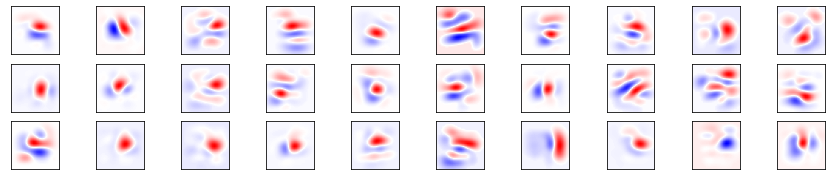

In [42]:
seed_i=2
nrows,ncols=3,10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
for ii in range(3):
    for jj in range(10):
        RF_fl_np=np.load('out_20211216/activation-max-example-neuron'+str(example_30_neuron[ii*10+jj])+'-outputs_seed_'+str(seed_i)+'_rcnn_Antolik2016.npy')
        temp=RF_fl_np[0,0]
        tempmax=np.max(np.abs(RF_fl_np[0,0]))
        axes[ii][jj].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[ii][jj].grid(False)#axes[ii,jj].axis('tight')
        axes[ii][jj].set_xticks([])
        axes[ii][jj].set_yticks([])
        
#fig.savefig('out_result_20211216/RFs_with_std_rCNN_neuron_example30neurons_activation_max.svg')        

### VCNN

In [44]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,6)
# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

for neuron_i in example_30_neuron:
    for i in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
        torch.manual_seed(seeds[i])    # reproducible
        torch.cuda.manual_seed(seeds[i])
        unit = neuron_i
        inputseed = 1
        sampleFlag = False
        sampleseed = 1
        output = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        outputs_vcnn=np.array(output.cpu().data.numpy())
        #np.save('out_20211216/activation-max-example-neuron'+str(neuron_i)+'-outputs_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy', outputs_vcnn)
        outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

        outs = np.log(testmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
        print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
        out_vcnn = np.copy(outs)
        #np.save('out_20211216/activation-max-example-neuron'+str(neuron_i)+'-acts_seed_'+str(i)+'_vcnn_sampleflag_false_Antolik2016.npy', out_vcnn)

outs.shape: (1, 103). Neuron 0 activation: 4.228301048278809
Test activation: outs.shape: (1, 103). Neuron 0 activation: 2.9775664806365967
outs.shape: (1, 103). Neuron 0 activation: 5.038876056671143
Test activation: outs.shape: (1, 103). Neuron 0 activation: 3.039931297302246
outs.shape: (1, 103). Neuron 0 activation: 5.3327531814575195
Test activation: outs.shape: (1, 103). Neuron 0 activation: 3.2033205032348633
outs.shape: (1, 103). Neuron 0 activation: 6.565993309020996
Test activation: outs.shape: (1, 103). Neuron 0 activation: 2.9640512466430664
outs.shape: (1, 103). Neuron 0 activation: 7.960564136505127
Test activation: outs.shape: (1, 103). Neuron 0 activation: 3.0631625652313232
outs.shape: (1, 103). Neuron 8 activation: 7.249556541442871
Test activation: outs.shape: (1, 103). Neuron 8 activation: 6.589256763458252
outs.shape: (1, 103). Neuron 8 activation: 6.308204650878906
Test activation: outs.shape: (1, 103). Neuron 8 activation: 6.275455474853516
outs.shape: (1, 103). 

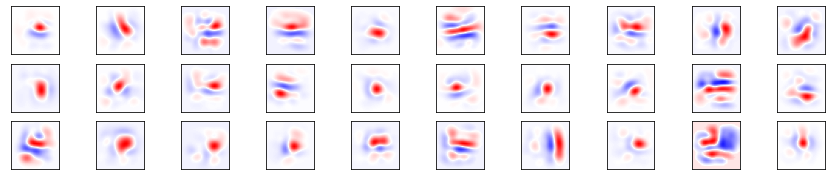

In [10]:
seed_i=2
nrows,ncols=3,10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
for ii in range(3):
    for jj in range(10):
        RF_fl_np=np.load('out_20211216/activation-max-example-neuron'+str(example_30_neuron[ii*10+jj])+'-outputs_seed_'+str(seed_i)+'_vcnn_sampleflag_false_Antolik2016.npy')
        temp=RF_fl_np[0,0]
        tempmax=np.max(np.abs(RF_fl_np[0,0]))
        axes[ii][jj].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[ii][jj].grid(False)#axes[ii,jj].axis('tight')
        axes[ii][jj].set_xticks([])
        axes[ii][jj].set_yticks([])
        
#fig.savefig('out_result_20211216/RFs_with_std_vCNN_neuron_example30neurons_activation_max.svg')        